<a href="https://colab.research.google.com/github/NandithaSHadligere/CulturalHeritage/blob/main/HeritageAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

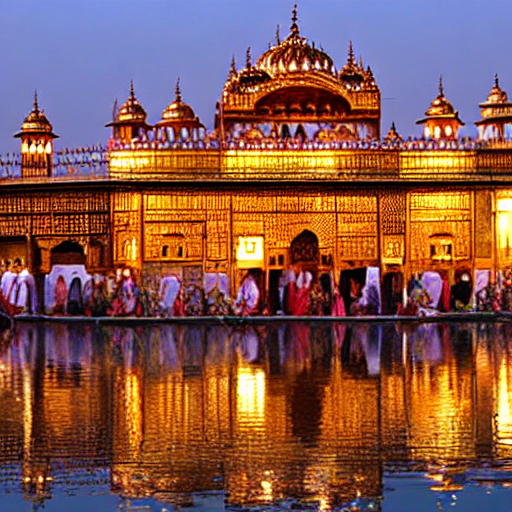

In [12]:
import torch
from diffusers import StableDiffusionPipeline
from IPython.display import display  # To display images in Jupyter Notebook

# Load the pre-trained Stable Diffusion model
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

# Function to generate an image
def generate_image(prompt, num_inference_steps=50, guidance_scale=7.5):
    with torch.no_grad():
        image = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
    return image

# Example usage
prompt = "Konarak temple"
image = generate_image(prompt)

# Display the image in Jupyter Notebook
display(image)

# Save the generated image
image.save("sun_temple.png")


Step 1: Generate Depth Map

In [ ]:
import torch
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Load MiDaS model
midas_model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas_model.eval()
midas_model.to("cuda")

# Load transforms to prepare the image for the model
transform = Compose([
    Resize(384),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def estimate_depth(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_input = transform(img).unsqueeze(0).to("cuda")

    with torch.no_grad():
        depth = midas_model(img_input)
        depth = depth.squeeze().cpu().numpy()

    depth_min = depth.min()
    depth_max = depth.max()
    depth_normalized = (depth - depth_min) / (depth_max - depth_min)

    return depth_normalized

# Estimate depth
depth_map = estimate_depth("sun_temple.png")
cv2.imwrite("depth_map.png", depth_map * 255)

Step 2: Create 3D Mesh

In [ ]:
import open3d as o3d
import numpy as np

def create_mesh_from_depth_map(depth_map_path, image_path):
    depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(image_path)

    h, w = depth_map.shape
    fx = fy = 1.0
    cx, cy = w / 2, h / 2

    # Create point cloud
    points = []
    colors = []
    for v in range(h):
        for u in range(w):
            z = depth_map[v, u] / 255.0
            if z > 0:
                x = (u - cx) * z / fx
                y = (v - cy) * z / fy
                points.append([x, y, z])
                colors.append(image[v, u] / 255.0)

    points = np.array(points)
    colors = np.array(colors)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    # Create mesh
    distances = point_cloud.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 3 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        point_cloud, o3d.utility.DoubleVector([radius, radius * 2])
    )

    mesh.compute_vertex_normals()

    return mesh

# Create 3D mesh
mesh = create_mesh_from_depth_map("depth_map.png", "sun_temple.png")
o3d.io.write_triangle_mesh("sun_temple_3d.ply", mesh)

In [ ]:
pip install open3d


In [ ]:
import open3d as o3d

# Load the 3D mesh from the .ply file
mesh = o3d.io.read_triangle_mesh("sun_temple_3d.ply")

# Visualize the 3D mesh
o3d.visualization.draw_geometries([mesh])